# Frechet Gesture Distance From Image Data Representation and Resnet-based AutoEncoder 

## Optional: Style selection

In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
# uncomment and execute line to try a new theme
#set_nb_theme('onedork')
#set_nb_theme('chesterish')
#set_nb_theme('grade3')
#set_nb_theme('oceans16')
#set_nb_theme('solarizedl')
#set_nb_theme('solarizedd')
set_nb_theme('monokai')

## Import
##### might not need all the import below 

In [2]:
import random
import numpy as np 
import math 
import sys
import csv 
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt 
from scipy import linalg
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from skimage.util import random_noise

#from data_loader.h36m_loader import Human36M
#from utils.data_utils import convert_dir_vec_to_pose, convert_pose_seq_to_dir_vec

[sys.path.append(i) for i in ['.', '..']]
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
from torch.utils.data import Dataset, DataLoader
#from data_loader.lmdb_data_loader import *

#from model.embedding_net import EmbeddingNet

## Config parameters

In [3]:
class Args:
    
    def __init__(self):
        self.name = 'gesture_autoencoder'

        self.train_data_path = 'data/ted_dataset/lmdb_train'
        self.val_data_path =  'data/ted_dataset/lmdb_val'
        self.test_data_path =  'data/ted_dataset/lmdb_test'

        self.model_save_path = 'output/train_h36m_gesture_autoencoder'
        self.random_seed =  -1

        # model params
        self.model = 'gesture_autoencoder'
        self.variational_encoding = False
        self.mean_dir_vec= [ 0.0154009, -0.9690125, -0.0884354, -0.0022264, -0.8655276, 0.4342174, -0.0035145, -0.8755367, -0.4121039, -0.9236511, 0.3061306, -0.0012415, -0.5155854,  0.8129665,  0.0871897, 0.2348464,  0.1846561,  0.8091402,  0.9271948,  0.2960011, -0.013189 ,  0.5233978,  0.8092403,  0.0725451, -0.2037076, 0.1924306,  0.8196916]
        self.mean_pose= [ 0.0000306,  0.0004946,  0.0008437,  0.0033759, -0.2051629, -0.0143453,  0.0031566, -0.3054764,  0.0411491,  0.0029072, -0.4254303, -0.001311 , -0.1458413, -0.1505532, -0.0138192, -0.2835603,  0.0670333,  0.0107002, -0.2280813,  0.112117 , 0.2087789,  0.1523502, -0.1521499, -0.0161503,  0.291909 , 0.0644232,  0.0040145,  0.2452035,  0.1115339,  0.2051307]

        # train params
        self.epochs= 500
        self.batch_size= 128
        self.learning_rate= 0.0005

        # dataset params
        self.motion_resampling_framerate= 15
        self.n_poses= 34
        self.n_pre_poses= 4
        self.subdivision_stride= 10
        self.loader_workers= 4
        
args = Args()

## Function utils
#### 1) Custom function

In [4]:
'''
activation = {}
def get_activation(name):
    def hook(generator, input, output):
        activation[name] = output.detach()
    return hook
'''



def view(tsne,filename,n_components):
    if tsne.shape[-1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(tsne[:,0], tsne[:,1], tsne[:,2])
    elif tsne.shape[-1]==2:
        fig = plt.figure()
        plt.scatter(tsne[:,0], tsne[:,1])
    np.savez(f'tsne{n_components}_{filename}', data=tsne)

    plt.show()

def calculate_latent_space_statistics(ls):
    ls = ls.cpu().data.numpy()
    mu = np.mean(ls, axis=0)
    sigma = np.cov(ls, rowvar = False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

#Compute fgd from latent space ls and lsn
def compute_fgd(ls, lsn):
    mu_ls, sigma_ls = calculate_latent_space_statistics(ls)
    mu_lsn, sigma_lsn = calculate_latent_space_statistics(lsn)
    fid = calculate_frechet_distance(mu_ls, sigma_ls, mu_lsn, sigma_lsn, eps=1e-6)
    return fid, mu_ls, mu_lsn, sigma_ls, sigma_lsn

'''
#Create random vectors
def create_random_vecs(n_data):    
    n_frames = 34
    rand = torch.empty(n_data*n_frames, 27)
    for i in range(n_data*n_frames):
        rand[i, :] = torch.normal(torch.mean(target_vecs.reshape(-1, 27), 0), torch.std(target_vecs.reshape(-1, 27), 0))
    rand = rand.reshape(-1, 34, 27)
    return rand
'''

'''
#Compute latent space from created random vectors
def compute_latent_space_noise(vecs):
    lsn = None
    generator.pose_encoder.fc_mu.register_forward_hook(get_activation('latent_space'))
    for i in range(0, n_data, 2):
        rand_data_current = vecs[i].unsqueeze(0)
        rand_data_next = vecs[i+1].unsqueeze(0)
        rand_data_ = torch.cat((rand_data_current, rand_data_next), 0)
        lsn = forward(i, rand_data_.to(device), generator, lsn)
    
    return lsn
'''
    
'''
def add_noise_on_pose(target, psnr):
    noise = torch.empty(target.shape).reshape(-1, 30)
    target_var = torch.std(target.reshape(-1,30),0) ** 2
    noise_std = torch.sqrt(target_var / psnr)
    mean, std = torch.zeros(30), noise_std
    for i in range(3, len(mean)):
        noise[..., i].normal_(mean[i], std[i])
    noise = noise.reshape(-1, 34, 10, 3)
    return target + noise
'''

#compute latent space from custom dataloader

def forward(idx, target_data, net, variational_encoding):
    
    #z, _, _ = generator.pose_encoder(target_data, False)
    #recon_data = generator.decoder(z)
    
    _, context_mu, context_logvar, pose_feat, pose_mu, pose_logvar, recon_data = \
        net(None, None, None, target_data, variational_encoding=variational_encoding)
    
    #act = activation['latent_space'].squeeze()
    #z = z.squeeze()
    
    if idx == 0:
        latent_spaces = pose_feat
    else :
        latent_spaces = torch.cat((latent_spaces, pose_feat), 0)
    return latent_spaces

def compute_latent_space(loader, net, variational_encoding, with_noise=False):
    ''' 
    with_noise: If set to True, save noise samples into npy file
    '''
    #generator.pose_encoder.fc_mu.register_forward_hook(get_activation('latent_space'))
    for i, (_,vecs) in enumerate(loader,0):
        target_data = vecs
        #vecs = vecs.reshape(len(vecs), args.n_poses, -1)
        _, context_mu, context_logvar, pose_feat, pose_mu, pose_logvar, recon_data = \
        net(None, None, None, target_data.to(device), variational_encoding=variational_encoding)
        
        if i == 0:
            latent_spaces = pose_feat
            #noises = noise
        else:
            #noises = np.concatenate((noises, noise), axis=0)
            latent_spaces = torch.cat((latent_spaces, pose_feat), 0)
        #lsn = forward(i, vecs.to(device), generator, lsn, args.variational_encoding)
        
    '''
    if with_noise:
        np.savez('noises_one_sample', noises)
    '''
        
    lsn = latent_spaces
    return lsn  

def compute_and_save_tsne(n_components, ls, lsn, psnr):
    if lsn is not None and psnr is not None:
        ls = torch.cat((ls, lsn), 0)
        filename = f'tsne_latent_spaces_gt_and_noise_{psnr}'
    else:
        filename = f'tsne_latent_spaces_gt'
        
    tls = TSNE(n_components=n_components, init='random').fit_transform(ls.detach().cpu().numpy())
    np.savez(filename, data=tls)
    return tls




#### 2) Function from the authors. DO NOT EDIT !

In [5]:
dir_vec_pairs = [(0, 1, 0.26), (1, 2, 0.18), (2, 3, 0.14), (1, 4, 0.22), (4, 5, 0.36),
                 (5, 6, 0.33), (1, 7, 0.22), (7, 8, 0.36), (8, 9, 0.33)]  # adjacency and bone length

def convert_dir_vec_to_pose(vec):
    vec = np.array(vec)

    if vec.shape[-1] != 3:
        vec = vec.reshape(vec.shape[:-1] + (-1, 3))

    if len(vec.shape) == 2:
        joint_pos = np.zeros((10, 3))
        for j, pair in enumerate(dir_vec_pairs):
            joint_pos[pair[1]] = joint_pos[pair[0]] + pair[2] * vec[j]
    elif len(vec.shape) == 3:
        joint_pos = np.zeros((vec.shape[0], 10, 3))
        for j, pair in enumerate(dir_vec_pairs):
            joint_pos[:, pair[1]] = joint_pos[:, pair[0]] + pair[2] * vec[:, j]
    elif len(vec.shape) == 4:  # (batch, seq, 9, 3)
        joint_pos = np.zeros((vec.shape[0], vec.shape[1], 10, 3))
        for j, pair in enumerate(dir_vec_pairs):
            joint_pos[:, :, pair[1]] = joint_pos[:, :, pair[0]] + pair[2] * vec[:, :, j]
    else:
        assert False

    return joint_pos


def convert_pose_seq_to_dir_vec(pose):
    if pose.shape[-1] != 3:
        pose = pose.reshape(pose.shape[:-1] + (-1, 3))

    if len(pose.shape) == 3:
        dir_vec = np.zeros((pose.shape[0], len(dir_vec_pairs), 3))
        for i, pair in enumerate(dir_vec_pairs):
            dir_vec[:, i] = pose[:, pair[1]] - pose[:, pair[0]]
            dir_vec[:, i, :] = normalize(dir_vec[:, i, :], axis=1)  # to unit length
    elif len(pose.shape) == 4:  # (batch, seq, ...)
        dir_vec = np.zeros((pose.shape[0], pose.shape[1], len(dir_vec_pairs), 3))
        for i, pair in enumerate(dir_vec_pairs):
            dir_vec[:, :, i] = pose[:, :, pair[1]] - pose[:, :, pair[0]]
        for j in range(dir_vec.shape[0]):  # batch
            for i in range(len(dir_vec_pairs)):
                dir_vec[j, :, i, :] = normalize(dir_vec[j, :, i, :], axis=1)  # to unit length
    else:
        assert False

    return dir_vec


In [6]:
train_subject = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9']
test_subject = ['S11']

class Human36M(Dataset):
    """ INIT """
    def __init__(self, path, mean_data, n_poses=34, is_train=True, augment=False, method=None, std=0, to_image=None, one_noise_to_all=False):
        n_poses = n_poses
        target_joints = [1, 6, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]  # see https://github.com/kenkra/3d-pose-baseline-vmd/wiki/body

        self.method = method
        self.std = std
        self.is_train = is_train
        self.augment = augment
        self.mean_data = mean_data
        self.data = []
        self.one_noise_to_all = one_noise_to_all
        self.noise = None
        
        if is_train:
            subjects = train_subject
        else:
            subjects = test_subject
            
        if self.one_noise_to_all:
            print('One noise sample by dataset')
            if self.method is not None:
                
                if hasattr(self, self.method):
                    noise_function = getattr(self, self.method)
                    noise = noise_function(np.empty((1,10,3)), self.std)
                    self.noise = noise
                    assert len(noise) != 2, "len(noise) = 2" #no temporal noise atm
            else:
                assert False, "There is no noise distribution in method i.e. method is None"
        else:
            print('One noise sample by gesture')
        # loading data and normalize
        frame_stride = 2
        data = np.load(path, allow_pickle=True)['positions_3d'].item()
        for subject, actions in data.items():
            if subject not in subjects:
                continue

            for action_name, positions in actions.items():
                positions = positions[:, target_joints]
                positions = self.normalize(positions)
                for f in range(0, len(positions), 10):
                    if f+n_poses*frame_stride > len(positions):
                        break
                    gesture = positions[f:f+n_poses*frame_stride:frame_stride]
                    self.data.append(gesture)

                    
                    
    """ GETITEM """                
    def __getitem__(self, index):
        poses = self.data[index]
        dir_vec = convert_pose_seq_to_dir_vec(poses)
        poses = convert_dir_vec_to_pose(dir_vec)
                
        '''Noise for data augmentation'''
        if self.augment:  # data augmentation by adding gaussian noises on joints coordinates            
            rand_val = random.random()
            if rand_val < 0.2:
                poses = poses.copy()
                poses += np.random.normal(0, 0.002 ** 0.5, poses.shape)
            else:
                poses = poses.copy()
                poses += np.random.normal(0, 0.0001 ** 0.5, poses.shape)
            
        '''Noise for data alteration for FGD sensitivity assessment'''
        if self.one_noise_to_all is False:
            if self.method is not None: #poses alteration by adding noises of different types
                if hasattr(self, self.method):
                    noise_function = getattr(self, self.method)
                    if len(noise_function(poses, self.std)) == 2: #temporal noise
                        self.noise, r = noise_function(poses, self.std)
                        poses = poses.copy()
                        poses[r:r+self.std] +=  self.noise
                    else:
                        poses = poses.copy()
                        self.noise = noise_function(poses, self.std)
                        poses += self.noise
        
                else:
                    raise NotImplementedError
        else:
            if self.method is not None:
                poses = poses.copy()
                poses += self.noise 
        
        dir_vec = convert_pose_seq_to_dir_vec(poses)
        dir_vec = dir_vec.reshape(dir_vec.shape[0], -1)
        dir_vec = dir_vec - self.mean_data

        poses = torch.from_numpy(poses).float()
        dir_vec = torch.from_numpy(dir_vec).float()
        return poses, dir_vec
    
    
    

    def __len__(self):
        return len(self.data)
    
    
    

    def normalize(self, data):

        # pose normalization
        for f in range(data.shape[0]):
            data[f, :] -= data[f, 2]
            data[f, :, (0, 1, 2)] = data[f, :, (0, 2, 1)]  # xy exchange
            data[f, :, 1] = -data[f, :, 1]  # invert y

        # frontalize based on hip joints
        for f in range(data.shape[0]):
            hip_vec = data[f, 1] - data[f, 0]
            angle = np.pi - np.math.atan2(hip_vec[2], hip_vec[0])  # angles on XZ plane
            if 180 > np.rad2deg(angle) > 0:
                pass
            elif 180 < np.rad2deg(angle) < 360:
                angle = angle - np.deg2rad(360)

            rot = self.rotation_matrix([0, 1, 0], angle)
            data[f] = np.matmul(data[f], rot)

        data = data[:, 2:]  # exclude hip joints
        return data

    @staticmethod
    def to_image(data, name):
        assert len(data.shape) == 3, "data has no valid shape to plot"
        plt.figure()
        plt.imsave(name+'.png', data.numpy())
        
    @staticmethod
    def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        axis = np.asarray(axis)
        axis = axis / math.sqrt(np.dot(axis, axis))
        a = math.cos(theta / 2.0)
        b, c, d = -axis * math.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    @staticmethod
    def saltandpepper_noise(data, std):
        u = np.random.uniform(size=data[0].shape) #Applying the same noise on every frame to avoid discontinuities
        noise = np.zeros(u.shape)
        cond0 = np.where(u<=std/2)
        cond1 = np.where((u>std/2) & (u<=std))
        noise[cond0[0], cond0[1]] = 0.2
        noise[cond1[0], cond1[1]] = -0.2
        return noise
    
    @staticmethod
    def gaussian_noise(data, std):
        noise = np.random.normal(0, std, data[0].shape)
        return noise #Applying the same noise on every frame to avoid discontinuities

    @staticmethod
    def temporal_noise(data, std):
        r = np.random.randint(1, data.shape[0] - std - 1)
        noise = np.random.normal(0, 0.003 ** 0.5, data[0].shape)
        return noise, r

In [7]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


def ConvNormRelu(in_channels, out_channels, downsample=False, padding=0, batchnorm=True):
    if not downsample:
        k = 3
        s = 1
    else:
        k = 4
        s = 2

    conv_block = nn.Conv1d(in_channels, out_channels, kernel_size=k, stride=s, padding=padding)
    norm_block = nn.BatchNorm1d(out_channels)

    if batchnorm:
        net = nn.Sequential(
            conv_block,
            norm_block,
            nn.LeakyReLU(0.2, True)
        )
    else:
        net = nn.Sequential(
            conv_block,
            nn.LeakyReLU(0.2, True)
        )

    return net


class PoseEncoderConv(nn.Module):
    def __init__(self, length, dim):
        super().__init__()

        self.net = nn.Sequential(
            ConvNormRelu(dim, 32, batchnorm=True),
            ConvNormRelu(32, 64, batchnorm=True),
            ConvNormRelu(64, 64, True, batchnorm=True),
            nn.Conv1d(64, 32, 3)
        )

        """ for 34 or 64 frames """
        self.out_net = nn.Sequential(
            #nn.Linear(864, 256),  # for 64 frames
            nn.Linear(384, 256),  # for 34 frames
            nn.BatchNorm1d(256),
            nn.LeakyReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(True),
            nn.Linear(128, 32),
        )
        
        """ for 18 frames """
        '''
        self.out_net = nn.Sequential(
            nn.Linear(128, 64), 
            nn.BatchNorm1d(64),
            nn.LeakyReLU(True),
            nn.Linear(64, 32)
        )
        '''

        self.fc_mu = nn.Linear(32, 32)
        self.fc_logvar = nn.Linear(32, 32)

    def forward(self, poses, variational_encoding):
        # encode
        poses = poses.transpose(1, 2)  # to (bs, dim, seq)
        out = self.net(poses)
        out = out.flatten(1)
        out = self.out_net(out)

        # return out, None, None
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)

        if variational_encoding:
            z = reparameterize(mu, logvar)
        else:
            z = mu
        return z, mu, logvar
    
class PoseDecoderConv(nn.Module):
    def __init__(self, length, dim, use_pre_poses=False):
        super().__init__()
        self.use_pre_poses = use_pre_poses

        feat_size = 32
        
        if use_pre_poses:
            self.pre_pose_net = nn.Sequential(
                nn.Linear(dim * 4, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 32),
            )
            feat_size += 32

        if length == 64:
            self.pre_net = nn.Sequential(
                nn.Linear(feat_size, 128),
                nn.BatchNorm1d(128),
                nn.LeakyReLU(True),
                nn.Linear(128, 256),
            )
        elif length == 34:
            self.pre_net = nn.Sequential(
                nn.Linear(feat_size, 64),
                nn.BatchNorm1d(64),
                nn.LeakyReLU(True),
                nn.Linear(64, 136),
            )
        elif length == 18:
            self.pre_net = nn.Sequential(
                nn.BatchNorm1d(feat_size),
                nn.LeakyReLU(True),
                nn.Linear(feat_size, 72),
            )
        
        else:
            assert False

        self.net = nn.Sequential(
            nn.ConvTranspose1d(4, 32, 3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose1d(32, 32, 3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, True),
            nn.Conv1d(32, 32, 3),
            nn.Conv1d(32, dim, 3),
        )

    def forward(self, feat, pre_poses=None):
        if self.use_pre_poses:
            pre_pose_feat = self.pre_pose_net(pre_poses.reshape(pre_poses.shape[0], -1))
            feat = torch.cat((pre_pose_feat, feat), dim=1)

        out = self.pre_net(feat)
        out = out.view(feat.shape[0], 4, -1)
        out = self.net(out)
        out = out.transpose(1, 2)
        return out
    
class EmbeddingNet(nn.Module):
    def __init__(self, args, pose_dim, n_frames, n_words, word_embed_size, word_embeddings, mode):
        super().__init__()
        if mode != 'pose':
            raise NotImplementedError 
            #self.context_encoder = ContextEncoder(args, n_frames, n_words, word_embed_size, word_embeddings)
            #self.pose_encoder = PoseEncoderConv(n_frames, pose_dim)
            #self.decoder = PoseDecoderFC(n_frames, pose_dim, use_pre_poses=True)
            #self.decoder = PoseDecoderGRU(n_frames, pose_dim)
        else:
            self.context_encoder = None
            self.pose_encoder = PoseEncoderConv(n_frames, pose_dim)
            self.decoder = PoseDecoderConv(n_frames, pose_dim)
        self.mode = mode

    def forward(self, in_text, in_audio, pre_poses, poses, input_mode=None, variational_encoding=False):
        if input_mode is None:
            assert self.mode is not None
            input_mode = self.mode

        # context
        if self.context_encoder is not None and in_text is not None and in_audio is not None:
            context_feat, context_mu, context_logvar = self.context_encoder(in_text, in_audio)
            # context_feat = F.normalize(context_feat, p=2, dim=1)
        else:
            context_feat = context_mu = context_logvar = None

        # poses
        if poses is not None:
            poses_feat, pose_mu, pose_logvar = self.pose_encoder(poses, variational_encoding)
            # poses_feat = F.normalize(poses_feat, p=2, dim=1)
        else:
            poses_feat = pose_mu = pose_logvar = None

        # decoder
        if input_mode == 'random':
            input_mode = 'speech' if random.random() > 0.5 else 'pose'

        if input_mode == 'speech':
            latent_feat = context_feat
        elif input_mode == 'pose':
            latent_feat = poses_feat
        else:
            assert False

        out_poses = self.decoder(latent_feat, pre_poses)

        return context_feat, context_mu, context_logvar, poses_feat, pose_mu, pose_logvar, out_poses

    def freeze_pose_nets(self):
        for param in self.pose_encoder.parameters():
            param.requires_grad = False
        for param in self.decoder.parameters():
            param.requires_grad = False

## Set up device, AE and load checkpoint 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pose_dim = 27

#create model
generator = EmbeddingNet(args, pose_dim, args.n_poses, None, None, None, mode='pose').to(device)

#Load trained model
generator.load_state_dict(torch.load(f'../Gesture-Generation-from-Trimodal-Context/output/train_h36m_gesture_autoencoder_noS11_{args.n_poses}f/gesture_autoencoder_checkpoint_best.bin')['gen_dict'])

<All keys matched successfully>

## Set up datasets

In [9]:
path  = '../Gesture-Generation-from-Trimodal-Context/data/h36m/data_3d_h36m.npz'
mean_dir_vec = np.squeeze(np.array(args.mean_dir_vec))

train_dataset = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=True, augment=False)
val_dataset = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True)

One noise sample by gesture
One noise sample by gesture


In [10]:
len(val_dataset)

5460

In [13]:
val_dataset_noisy_ = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method='gaussian_noise', std=0.1)
val_dataset_noisy_ = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method='gaussian_noise', std=0.1, one_noise_to_all=True)

#test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)

One noise sample by gesture
One noise sample by dataset


## Extract latent space from clean validation dataset


In [ ]:
latent_spaces = None
dataset = test_loader
target_poses, target_vecs = None, None
save = False

#at the end of the loop, latent_spaces is the concatenation of all latent space computed from the target_vec
for idx, (target_pose, target_vec) in enumerate(dataset,0):
    latent_spaces = forward(idx, target_vec.to(device), generator, latent_spaces, args.variational_encoding)
    #Concatenation
    if target_poses is None and target_vecs is None:
        target_poses, target_vecs = target_pose, target_vec
    else:
        target_poses, target_vecs = torch.cat((target_poses, target_pose), 0), torch.cat((target_vecs, target_vec), 0)
        #target_vecs_un = torch.cat((target_vecs_un, target_vec_un), 0)
if save:
    np.savez('train_gestures_gt_vecs', data = target_vecs)
    np.savez('train_gestures_gt_poses', data = target_poses)

## Concatenate poses from noisy dataloader to save and later visualize noisy motion

In [29]:
ALL_NOISE = ['gaussian_noise', 'saltandpepper_noise', 'temporal_noise']
method = 'gaussian_noise'
method_str = method.split('_')[0]
save = False

if method not in ALL_NOISE:
    raise NotImplementedError
    
if method == 'gaussian_noise':
    stds = [0.0316, 0.0447, 0.0548, 0.1, 0.3163]
elif method == 'saltandpepper_noise':
    stds = [0.1,0.15,0.2] #This is not noise std!
elif method == 'temporal_noise':
    stds = [1,5,10] #This is not noise std!

In [ ]:
save = False

for std in tqdm(stds):
    
    val_dataset_noisy = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method=method, std=std)
    test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)

    dataset = test_loader_noisy
    target_poses = None

    for idx, (target_pose, _) in enumerate(dataset,0):
        #Concatenation
        if target_poses is None:
            target_poses= target_pose
        else:
            target_poses = torch.cat((target_poses, target_pose), 0)
if save:
    np.savez(f'gestures_gt_noise_{method_str}_{std}_s2', data = target_poses)

## Compute FGDs between clean and noisy validation dataset

One noise sample by gesture


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [10:37<00:00, 12.75s/it]


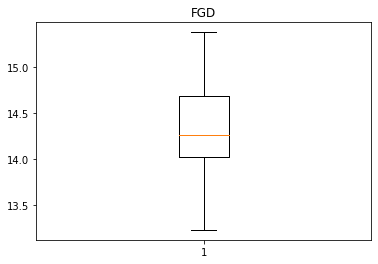

FGD mean and std for noisy data with psnr of  0.0316 : 14.323991337855919 0.4649132225529914
One noise sample by gesture


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [10:44<00:00, 12.89s/it]


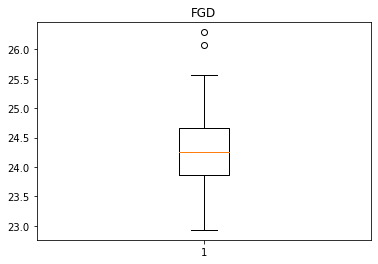

FGD mean and std for noisy data with psnr of  0.0447 : 24.3297147894632 0.6948057342724702
One noise sample by gesture


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [10:24<00:00, 12.48s/it]


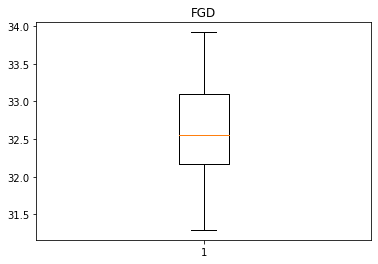

FGD mean and std for noisy data with psnr of  0.0548 : 32.59075250923375 0.6722467811464532
One noise sample by gesture


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [10:28<00:00, 12.58s/it]


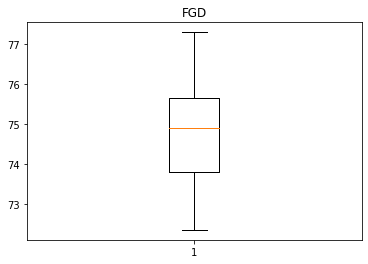

FGD mean and std for noisy data with psnr of  0.1 : 74.73345028482193 1.1919437189371687
One noise sample by gesture


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [10:39<00:00, 12.78s/it]


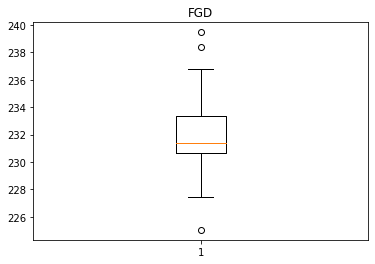

FGD mean and std for noisy data with psnr of  0.3163 : 231.97199769810598 2.5875796877367336


In [31]:
n = 50 #number of test
save = True
#Writing FGD txt file for each std and then load it afterwards to plot it better 

cov_ls, cov_lsn = np.empty((n*len(stds), 32, 32)), np.empty((n*len(stds), 32, 32))
mean_ls, mean_lsn = np.empty((n*len(stds), 32)), np.empty((n*len(stds), 32))

latent_spaces_all = []
latent_spaces_noisy_all = []

if save:
    with open(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2.txt','w') as f: 
        j = 0
        for std in stds:
            fgds = []
            val_dataset_noisy = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method=method, std=std)
            test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)
            for _ in tqdm(range(n)):

                latent_spaces = compute_latent_space(test_loader, generator, args.variational_encoding)
                latent_spaces_noisy_gt = compute_latent_space(test_loader_noisy, generator, args.variational_encoding, with_noise=True)
                latent_spaces_all.append(latent_spaces.detach().cpu().numpy())
                latent_spaces_noisy_all.append(latent_spaces_noisy_gt.detach().cpu().numpy())
                fgd, mean_ls_, mean_lsn_, cov_ls_, cov_lsn_  = compute_fgd(latent_spaces, latent_spaces_noisy_gt)
                mean_ls[j], mean_lsn[j], cov_ls[j], cov_lsn[j] = mean_ls_, mean_lsn_, cov_ls_, cov_lsn_
                fgds.append(fgd)
                j = j+1

            fig1, ax1 = plt.subplots()
            ax1.set_title('FGD')
            ax1.boxplot(fgds)
            plt.show()

            print('FGD mean and std for noisy data with psnr of ', std , ':', np.array(fgds).mean(), np.array(fgds).std())
            f.write(f'{std} {np.array(fgds).mean()} {np.array(fgds).std()}\n')
            
    np.savez_compressed(f'stats_{method}', 
                        mean_ls = mean_ls, 
                        mean_lsn = mean_lsn, 
                        cov_ls = cov_ls, 
                        cov_lsn = cov_lsn,
                        latent_spaces = np.array(latent_spaces_all),
                        latent_spaces_noisy = np.array(latent_spaces_noisy_all))
    
else:
    for std in  stds:
        fgds = []
        val_dataset_noisy = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method=method, std=std)
        test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)
        for _ in tqdm(range(n)):

            #latent_spaces = compute_latent_space(test_loader, generator, args.variational_encoding)
            latent_spaces_noisy_gt = compute_latent_space(test_loader_noisy, generator, args.variational_encoding, with_noise=True)
            #fgd, mean_ls_, mean_lsn_, cov_ls_, cov_lsn_  = compute_fgd(latent_spaces, latent_spaces_noisy_gt)
            
        '''   
        fig1, ax1 = plt.subplots()
        ax1.set_title('FGD')
        ax1.boxplot(fgds)
        plt.show()
        '''
        #print('FGD mean and std for noisy data with psnr of ', std , ':', np.array(fgds).mean(), np.array(fgds).std())

## Plot FGD along psnr

In [ ]:
save = True

with open(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2.txt') as file:
    lines = file.readlines()
    x = np.arange(len(lines))
    zeta = np.empty(len(lines))
    mean = np.empty(len(lines))
    std = np.empty(len(lines))
    for i, line in enumerate(lines):
        zeta_, mean_, std_=line.split(" ")
        zeta_, mean_, std_ = float(zeta_), float(mean_), float(std_)
        zeta[i], mean[i], std[i] = zeta_, mean_, std_
    
fig, ax = plt.subplots()
ax.set_ylabel('Fréchet Gesture Distance')
ax.set_xticks(x)
ax.set_xticklabels(zeta)
ax.set_title(f'Fréchet Gesture Distance evolution with $\zeta$ ({method_str} noise)')
ax.bar(x, mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

plt.tight_layout()
if save:
    plt.savefig(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2.png')
else:
    plt.show()

## What happens when adding same noise sample to all frames from dataset

  0%|                                                                                        | 0/50 [00:00<?, ?it/s]

One noise sample by dataset


  2%|█▌                                                                              | 1/50 [00:15<12:33, 15.38s/it]

One noise sample by dataset


  4%|███▏                                                                            | 2/50 [00:30<12:00, 15.01s/it]

One noise sample by dataset


  6%|████▊                                                                           | 3/50 [00:45<11:45, 15.00s/it]

One noise sample by dataset


  8%|██████▍                                                                         | 4/50 [01:00<11:29, 14.98s/it]

One noise sample by dataset


 10%|████████                                                                        | 5/50 [01:15<11:21, 15.14s/it]

One noise sample by dataset


 12%|█████████▌                                                                      | 6/50 [01:30<11:06, 15.15s/it]

One noise sample by dataset


 14%|███████████▏                                                                    | 7/50 [01:45<10:51, 15.16s/it]

One noise sample by dataset


 16%|████████████▊                                                                   | 8/50 [02:02<10:51, 15.50s/it]

One noise sample by dataset


 18%|██████████████▍                                                                 | 9/50 [02:18<10:49, 15.85s/it]

One noise sample by dataset


 20%|███████████████▊                                                               | 10/50 [02:34<10:38, 15.96s/it]

One noise sample by dataset


 22%|█████████████████▍                                                             | 11/50 [02:50<10:20, 15.92s/it]

One noise sample by dataset


 24%|██████████████████▉                                                            | 12/50 [03:06<09:59, 15.78s/it]

One noise sample by dataset


 26%|████████████████████▌                                                          | 13/50 [03:20<09:31, 15.45s/it]

One noise sample by dataset


 28%|██████████████████████                                                         | 14/50 [03:36<09:14, 15.40s/it]

One noise sample by dataset


 30%|███████████████████████▋                                                       | 15/50 [03:51<09:02, 15.51s/it]

One noise sample by dataset


 32%|█████████████████████████▎                                                     | 16/50 [04:07<08:48, 15.55s/it]

One noise sample by dataset


 34%|██████████████████████████▊                                                    | 17/50 [04:22<08:26, 15.34s/it]

One noise sample by dataset


 36%|████████████████████████████▍                                                  | 18/50 [04:37<08:03, 15.12s/it]

One noise sample by dataset


 38%|██████████████████████████████                                                 | 19/50 [04:51<07:46, 15.06s/it]

One noise sample by dataset


 40%|███████████████████████████████▌                                               | 20/50 [05:06<07:25, 14.86s/it]

One noise sample by dataset


 42%|█████████████████████████████████▏                                             | 21/50 [05:20<07:09, 14.80s/it]

One noise sample by dataset


 44%|██████████████████████████████████▊                                            | 22/50 [05:35<06:55, 14.84s/it]

One noise sample by dataset


 46%|████████████████████████████████████▎                                          | 23/50 [05:50<06:39, 14.79s/it]

One noise sample by dataset


 48%|█████████████████████████████████████▉                                         | 24/50 [06:05<06:26, 14.88s/it]

One noise sample by dataset


 50%|███████████████████████████████████████▌                                       | 25/50 [06:20<06:14, 14.96s/it]

One noise sample by dataset


 52%|█████████████████████████████████████████                                      | 26/50 [06:36<06:03, 15.13s/it]

One noise sample by dataset


 54%|██████████████████████████████████████████▋                                    | 27/50 [06:52<05:51, 15.29s/it]

One noise sample by dataset


 56%|████████████████████████████████████████████▏                                  | 28/50 [07:09<05:49, 15.89s/it]

One noise sample by dataset


 58%|█████████████████████████████████████████████▊                                 | 29/50 [07:25<05:32, 15.84s/it]

One noise sample by dataset


 60%|███████████████████████████████████████████████▍                               | 30/50 [07:41<05:18, 15.92s/it]

One noise sample by dataset


 62%|████████████████████████████████████████████████▉                              | 31/50 [07:56<05:01, 15.88s/it]

One noise sample by dataset


 64%|██████████████████████████████████████████████████▌                            | 32/50 [08:13<04:48, 16.00s/it]

One noise sample by dataset


 66%|████████████████████████████████████████████████████▏                          | 33/50 [08:29<04:33, 16.08s/it]

One noise sample by dataset


 68%|█████████████████████████████████████████████████████▋                         | 34/50 [08:45<04:15, 15.95s/it]

One noise sample by dataset


 70%|███████████████████████████████████████████████████████▎                       | 35/50 [08:59<03:53, 15.57s/it]

One noise sample by dataset


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [09:14<03:33, 15.27s/it]

One noise sample by dataset


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [09:29<03:18, 15.25s/it]

One noise sample by dataset


 76%|████████████████████████████████████████████████████████████                   | 38/50 [09:43<02:59, 14.97s/it]

One noise sample by dataset


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [09:59<02:46, 15.14s/it]

One noise sample by dataset


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [10:13<02:28, 14.87s/it]

One noise sample by dataset


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [10:28<02:13, 14.84s/it]

One noise sample by dataset


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [10:43<01:58, 14.82s/it]

One noise sample by dataset


 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [10:57<01:43, 14.73s/it]

One noise sample by dataset


 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [11:12<01:27, 14.63s/it]

One noise sample by dataset


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [11:27<01:14, 14.88s/it]

One noise sample by dataset


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [11:44<01:01, 15.49s/it]

One noise sample by dataset


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [11:59<00:46, 15.34s/it]

One noise sample by dataset


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [12:14<00:30, 15.26s/it]

One noise sample by dataset


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [12:30<00:15, 15.33s/it]

One noise sample by dataset


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [12:45<00:00, 15.32s/it]


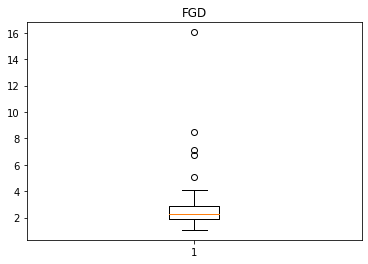

FGD mean and std for noisy data with psnr of  0.0316 : 2.884444045952023 2.3894963876916018


  0%|                                                                                        | 0/50 [00:00<?, ?it/s]

One noise sample by dataset


  2%|█▌                                                                              | 1/50 [00:15<12:25, 15.21s/it]

One noise sample by dataset


  4%|███▏                                                                            | 2/50 [00:30<12:24, 15.51s/it]

One noise sample by dataset


  6%|████▊                                                                           | 3/50 [00:46<12:02, 15.36s/it]

One noise sample by dataset


  8%|██████▍                                                                         | 4/50 [01:00<11:30, 15.00s/it]

One noise sample by dataset


 10%|████████                                                                        | 5/50 [01:15<11:12, 14.93s/it]

One noise sample by dataset


 12%|█████████▌                                                                      | 6/50 [01:29<10:45, 14.68s/it]

One noise sample by dataset


 14%|███████████▏                                                                    | 7/50 [01:45<10:42, 14.95s/it]

One noise sample by dataset


 16%|████████████▊                                                                   | 8/50 [02:01<10:43, 15.33s/it]

One noise sample by dataset


 18%|██████████████▍                                                                 | 9/50 [02:17<10:36, 15.53s/it]

One noise sample by dataset


 20%|███████████████▊                                                               | 10/50 [02:33<10:32, 15.82s/it]

One noise sample by dataset


 22%|█████████████████▍                                                             | 11/50 [02:49<10:14, 15.76s/it]

One noise sample by dataset


 24%|██████████████████▉                                                            | 12/50 [03:04<09:53, 15.62s/it]

One noise sample by dataset


 26%|████████████████████▌                                                          | 13/50 [03:20<09:37, 15.59s/it]

One noise sample by dataset


 28%|██████████████████████                                                         | 14/50 [03:35<09:23, 15.64s/it]

One noise sample by dataset


 30%|███████████████████████▋                                                       | 15/50 [03:51<09:12, 15.79s/it]

One noise sample by dataset


 32%|█████████████████████████▎                                                     | 16/50 [04:09<09:18, 16.43s/it]

One noise sample by dataset


 34%|██████████████████████████▊                                                    | 17/50 [04:26<09:00, 16.38s/it]

One noise sample by dataset


 36%|████████████████████████████▍                                                  | 18/50 [04:41<08:36, 16.15s/it]

One noise sample by dataset


 38%|██████████████████████████████                                                 | 19/50 [04:57<08:14, 15.95s/it]

One noise sample by dataset


 40%|███████████████████████████████▌                                               | 20/50 [05:13<08:02, 16.10s/it]

One noise sample by dataset


 42%|█████████████████████████████████▏                                             | 21/50 [05:29<07:42, 15.94s/it]

One noise sample by dataset


 44%|██████████████████████████████████▊                                            | 22/50 [05:45<07:26, 15.93s/it]

One noise sample by dataset


 46%|████████████████████████████████████▎                                          | 23/50 [06:01<07:11, 15.97s/it]

One noise sample by dataset


 48%|█████████████████████████████████████▉                                         | 24/50 [06:16<06:53, 15.89s/it]

One noise sample by dataset


 50%|███████████████████████████████████████▌                                       | 25/50 [06:32<06:36, 15.85s/it]

One noise sample by dataset


 52%|█████████████████████████████████████████                                      | 26/50 [06:49<06:25, 16.06s/it]

One noise sample by dataset


 54%|██████████████████████████████████████████▋                                    | 27/50 [07:04<06:05, 15.91s/it]

One noise sample by dataset


 56%|████████████████████████████████████████████▏                                  | 28/50 [07:20<05:46, 15.75s/it]

One noise sample by dataset


 58%|█████████████████████████████████████████████▊                                 | 29/50 [07:35<05:28, 15.66s/it]

One noise sample by dataset


 60%|███████████████████████████████████████████████▍                               | 30/50 [07:51<05:16, 15.82s/it]

One noise sample by dataset


 62%|████████████████████████████████████████████████▉                              | 31/50 [08:07<05:00, 15.81s/it]

One noise sample by dataset


 64%|██████████████████████████████████████████████████▌                            | 32/50 [08:23<04:42, 15.71s/it]

One noise sample by dataset


 66%|████████████████████████████████████████████████████▏                          | 33/50 [08:38<04:24, 15.53s/it]

One noise sample by dataset


 68%|█████████████████████████████████████████████████████▋                         | 34/50 [08:53<04:06, 15.43s/it]

One noise sample by dataset


 70%|███████████████████████████████████████████████████████▎                       | 35/50 [09:08<03:49, 15.33s/it]

One noise sample by dataset


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [09:24<03:36, 15.49s/it]

One noise sample by dataset


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [09:39<03:20, 15.43s/it]

One noise sample by dataset


 76%|████████████████████████████████████████████████████████████                   | 38/50 [09:54<03:03, 15.29s/it]

One noise sample by dataset


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [10:10<02:48, 15.35s/it]

One noise sample by dataset


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [10:25<02:33, 15.32s/it]

One noise sample by dataset


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [10:41<02:19, 15.55s/it]

One noise sample by dataset


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [10:57<02:04, 15.57s/it]

One noise sample by dataset


 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [11:12<01:48, 15.53s/it]

One noise sample by dataset


 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [11:28<01:34, 15.71s/it]

One noise sample by dataset


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [11:44<01:18, 15.68s/it]

One noise sample by dataset


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [11:59<01:02, 15.58s/it]

One noise sample by dataset


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [12:15<00:46, 15.53s/it]

One noise sample by dataset


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [12:30<00:31, 15.61s/it]

One noise sample by dataset


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [12:46<00:15, 15.56s/it]

One noise sample by dataset


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [13:01<00:00, 15.63s/it]


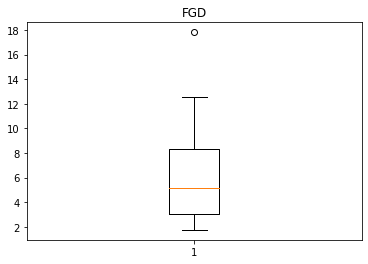

FGD mean and std for noisy data with psnr of  0.0447 : 5.8192383735574955 3.410824924744039


  0%|                                                                                        | 0/50 [00:00<?, ?it/s]

One noise sample by dataset


  2%|█▌                                                                              | 1/50 [00:15<12:50, 15.72s/it]

One noise sample by dataset


  4%|███▏                                                                            | 2/50 [00:30<12:00, 15.00s/it]

One noise sample by dataset


  6%|████▊                                                                           | 3/50 [00:44<11:38, 14.86s/it]

One noise sample by dataset


  8%|██████▍                                                                         | 4/50 [00:59<11:21, 14.81s/it]

One noise sample by dataset


 10%|████████                                                                        | 5/50 [01:14<11:12, 14.94s/it]

One noise sample by dataset


 12%|█████████▌                                                                      | 6/50 [01:30<11:12, 15.28s/it]

One noise sample by dataset


 14%|███████████▏                                                                    | 7/50 [01:45<10:54, 15.22s/it]

One noise sample by dataset


 16%|████████████▊                                                                   | 8/50 [02:00<10:31, 15.04s/it]

One noise sample by dataset


 18%|██████████████▍                                                                 | 9/50 [02:16<10:25, 15.26s/it]

One noise sample by dataset


 20%|███████████████▊                                                               | 10/50 [02:32<10:25, 15.65s/it]

One noise sample by dataset


 22%|█████████████████▍                                                             | 11/50 [02:48<10:07, 15.57s/it]

One noise sample by dataset


 24%|██████████████████▉                                                            | 12/50 [03:04<09:59, 15.78s/it]

One noise sample by dataset


 26%|████████████████████▌                                                          | 13/50 [03:20<09:46, 15.84s/it]

One noise sample by dataset


 28%|██████████████████████                                                         | 14/50 [03:36<09:30, 15.84s/it]

One noise sample by dataset


 30%|███████████████████████▋                                                       | 15/50 [03:51<09:12, 15.77s/it]

One noise sample by dataset


 32%|█████████████████████████▎                                                     | 16/50 [04:07<08:54, 15.71s/it]

One noise sample by dataset


 34%|██████████████████████████▊                                                    | 17/50 [04:23<08:41, 15.82s/it]

One noise sample by dataset


 36%|████████████████████████████▍                                                  | 18/50 [04:39<08:24, 15.78s/it]

One noise sample by dataset


 38%|██████████████████████████████                                                 | 19/50 [04:54<08:05, 15.68s/it]

One noise sample by dataset


 40%|███████████████████████████████▌                                               | 20/50 [05:09<07:46, 15.56s/it]

One noise sample by dataset


 42%|█████████████████████████████████▏                                             | 21/50 [05:25<07:28, 15.48s/it]

One noise sample by dataset


 44%|██████████████████████████████████▊                                            | 22/50 [05:40<07:08, 15.31s/it]

One noise sample by dataset


 46%|████████████████████████████████████▎                                          | 23/50 [05:54<06:46, 15.06s/it]

One noise sample by dataset


 48%|█████████████████████████████████████▉                                         | 24/50 [06:10<06:36, 15.24s/it]

One noise sample by dataset


 50%|███████████████████████████████████████▌                                       | 25/50 [06:26<06:29, 15.59s/it]

One noise sample by dataset


 52%|█████████████████████████████████████████                                      | 26/50 [06:42<06:16, 15.71s/it]

One noise sample by dataset


 54%|██████████████████████████████████████████▋                                    | 27/50 [06:58<06:00, 15.68s/it]

One noise sample by dataset


 56%|████████████████████████████████████████████▏                                  | 28/50 [07:14<05:49, 15.86s/it]

One noise sample by dataset


 58%|█████████████████████████████████████████████▊                                 | 29/50 [07:30<05:32, 15.83s/it]

One noise sample by dataset


 60%|███████████████████████████████████████████████▍                               | 30/50 [07:46<05:17, 15.87s/it]

One noise sample by dataset


 62%|████████████████████████████████████████████████▉                              | 31/50 [08:01<04:58, 15.72s/it]

One noise sample by dataset


 64%|██████████████████████████████████████████████████▌                            | 32/50 [08:18<04:47, 15.98s/it]

One noise sample by dataset


 66%|████████████████████████████████████████████████████▏                          | 33/50 [08:34<04:33, 16.08s/it]

One noise sample by dataset


 68%|█████████████████████████████████████████████████████▋                         | 34/50 [08:50<04:16, 16.03s/it]

One noise sample by dataset


 70%|███████████████████████████████████████████████████████▎                       | 35/50 [09:06<03:58, 15.90s/it]

One noise sample by dataset


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [09:21<03:39, 15.69s/it]

One noise sample by dataset


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [09:36<03:21, 15.50s/it]

One noise sample by dataset


 76%|████████████████████████████████████████████████████████████                   | 38/50 [09:51<03:04, 15.35s/it]

One noise sample by dataset


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [10:06<02:48, 15.28s/it]

One noise sample by dataset


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [10:21<02:32, 15.21s/it]

One noise sample by dataset


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [10:36<02:16, 15.16s/it]

One noise sample by dataset


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [10:51<02:01, 15.15s/it]

One noise sample by dataset


 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [11:06<01:45, 15.14s/it]

One noise sample by dataset


 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [11:21<01:30, 15.14s/it]

One noise sample by dataset


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [11:37<01:16, 15.21s/it]

One noise sample by dataset


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [11:52<01:00, 15.15s/it]

One noise sample by dataset


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [12:08<00:46, 15.44s/it]

One noise sample by dataset


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [12:23<00:30, 15.31s/it]

One noise sample by dataset


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [12:38<00:15, 15.24s/it]

One noise sample by dataset


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [12:53<00:00, 15.47s/it]


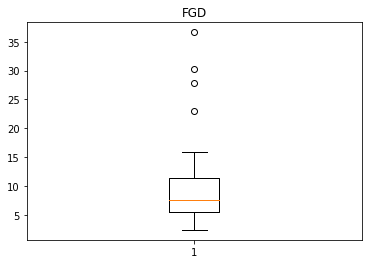

FGD mean and std for noisy data with psnr of  0.0548 : 9.749728412562899 6.983235166721723


  0%|                                                                                        | 0/50 [00:00<?, ?it/s]

One noise sample by dataset


  2%|█▌                                                                              | 1/50 [00:19<16:10, 19.81s/it]

One noise sample by dataset


  4%|███▏                                                                            | 2/50 [00:43<17:30, 21.89s/it]

One noise sample by dataset


  6%|████▊                                                                           | 3/50 [01:06<17:35, 22.45s/it]

One noise sample by dataset


  8%|██████▍                                                                         | 4/50 [01:26<16:24, 21.39s/it]

One noise sample by dataset


 10%|████████                                                                        | 5/50 [01:43<15:03, 20.08s/it]

One noise sample by dataset


 12%|█████████▌                                                                      | 6/50 [02:03<14:36, 19.92s/it]

One noise sample by dataset


 14%|███████████▏                                                                    | 7/50 [02:20<13:38, 19.02s/it]

One noise sample by dataset


 16%|████████████▊                                                                   | 8/50 [02:36<12:39, 18.08s/it]

One noise sample by dataset


 18%|██████████████▍                                                                 | 9/50 [02:53<12:04, 17.68s/it]

One noise sample by dataset


 20%|███████████████▊                                                               | 10/50 [03:09<11:27, 17.18s/it]

One noise sample by dataset


 22%|█████████████████▍                                                             | 11/50 [03:25<10:51, 16.72s/it]

One noise sample by dataset


 24%|██████████████████▉                                                            | 12/50 [03:40<10:19, 16.30s/it]

One noise sample by dataset


 26%|████████████████████▌                                                          | 13/50 [03:57<10:08, 16.44s/it]

One noise sample by dataset


 28%|██████████████████████                                                         | 14/50 [04:13<09:48, 16.36s/it]

One noise sample by dataset


 30%|███████████████████████▋                                                       | 15/50 [04:28<09:21, 16.04s/it]

One noise sample by dataset


 32%|█████████████████████████▎                                                     | 16/50 [04:43<08:56, 15.79s/it]

One noise sample by dataset


 34%|██████████████████████████▊                                                    | 17/50 [04:58<08:31, 15.50s/it]

One noise sample by dataset


 36%|████████████████████████████▍                                                  | 18/50 [05:14<08:14, 15.44s/it]

One noise sample by dataset


 38%|██████████████████████████████                                                 | 19/50 [05:29<07:57, 15.40s/it]

One noise sample by dataset


 40%|███████████████████████████████▌                                               | 20/50 [05:44<07:38, 15.27s/it]

One noise sample by dataset


 42%|█████████████████████████████████▏                                             | 21/50 [05:59<07:20, 15.18s/it]

One noise sample by dataset


 44%|██████████████████████████████████▊                                            | 22/50 [06:14<07:03, 15.13s/it]

One noise sample by dataset


 46%|████████████████████████████████████▎                                          | 23/50 [06:29<06:46, 15.07s/it]

One noise sample by dataset


 48%|█████████████████████████████████████▉                                         | 24/50 [06:44<06:36, 15.24s/it]

One noise sample by dataset


 50%|███████████████████████████████████████▌                                       | 25/50 [07:00<06:22, 15.31s/it]

One noise sample by dataset


 52%|█████████████████████████████████████████                                      | 26/50 [07:15<06:08, 15.36s/it]

One noise sample by dataset


 54%|██████████████████████████████████████████▋                                    | 27/50 [07:30<05:51, 15.29s/it]

One noise sample by dataset


 56%|████████████████████████████████████████████▏                                  | 28/50 [07:45<05:34, 15.19s/it]

One noise sample by dataset


 58%|█████████████████████████████████████████████▊                                 | 29/50 [08:01<05:19, 15.21s/it]

One noise sample by dataset


 60%|███████████████████████████████████████████████▍                               | 30/50 [08:16<05:05, 15.29s/it]

One noise sample by dataset


 62%|████████████████████████████████████████████████▉                              | 31/50 [08:31<04:49, 15.25s/it]

One noise sample by dataset


 64%|██████████████████████████████████████████████████▌                            | 32/50 [08:46<04:33, 15.18s/it]

One noise sample by dataset


 66%|████████████████████████████████████████████████████▏                          | 33/50 [09:02<04:18, 15.22s/it]

One noise sample by dataset


 68%|█████████████████████████████████████████████████████▋                         | 34/50 [09:17<04:02, 15.19s/it]

One noise sample by dataset


 70%|███████████████████████████████████████████████████████▎                       | 35/50 [09:32<03:47, 15.15s/it]

One noise sample by dataset


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [09:47<03:31, 15.12s/it]

One noise sample by dataset


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [10:02<03:17, 15.16s/it]

One noise sample by dataset


 76%|████████████████████████████████████████████████████████████                   | 38/50 [10:17<03:01, 15.15s/it]

One noise sample by dataset


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [10:33<02:47, 15.20s/it]

One noise sample by dataset


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [10:48<02:32, 15.26s/it]

One noise sample by dataset


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [11:03<02:16, 15.19s/it]

One noise sample by dataset


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [11:18<02:00, 15.02s/it]

One noise sample by dataset


 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [11:32<01:44, 14.90s/it]

One noise sample by dataset


 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [11:47<01:28, 14.82s/it]

One noise sample by dataset


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [12:02<01:14, 14.93s/it]

One noise sample by dataset


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [12:17<00:59, 14.94s/it]

One noise sample by dataset


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [12:32<00:44, 14.95s/it]

One noise sample by dataset


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [12:47<00:30, 15.01s/it]

One noise sample by dataset


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [13:03<00:15, 15.32s/it]

One noise sample by dataset


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [13:19<00:00, 15.98s/it]


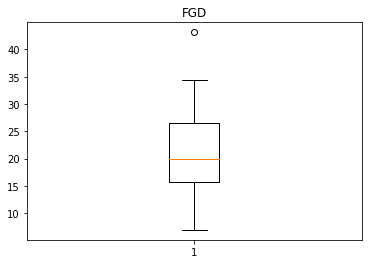

FGD mean and std for noisy data with psnr of  0.1 : 21.292898090634665 7.240564391846891


  0%|                                                                                        | 0/50 [00:00<?, ?it/s]

One noise sample by dataset


  2%|█▌                                                                              | 1/50 [00:15<12:16, 15.03s/it]

One noise sample by dataset


  4%|███▏                                                                            | 2/50 [00:30<12:03, 15.08s/it]

One noise sample by dataset


  6%|████▊                                                                           | 3/50 [00:45<11:51, 15.14s/it]

One noise sample by dataset


  8%|██████▍                                                                         | 4/50 [01:00<11:31, 15.04s/it]

One noise sample by dataset


 10%|████████                                                                        | 5/50 [01:15<11:17, 15.06s/it]

One noise sample by dataset


 12%|█████████▌                                                                      | 6/50 [01:30<11:00, 15.00s/it]

One noise sample by dataset


 14%|███████████▏                                                                    | 7/50 [01:45<10:47, 15.07s/it]

One noise sample by dataset


 16%|████████████▊                                                                   | 8/50 [02:00<10:31, 15.04s/it]

One noise sample by dataset


 18%|██████████████▍                                                                 | 9/50 [02:15<10:16, 15.04s/it]

One noise sample by dataset


 20%|███████████████▊                                                               | 10/50 [02:30<10:00, 15.01s/it]

One noise sample by dataset


 22%|█████████████████▍                                                             | 11/50 [02:45<09:43, 14.96s/it]

One noise sample by dataset


 24%|██████████████████▉                                                            | 12/50 [03:00<09:27, 14.94s/it]

One noise sample by dataset


 26%|████████████████████▌                                                          | 13/50 [03:15<09:15, 15.01s/it]

One noise sample by dataset


 28%|██████████████████████                                                         | 14/50 [03:30<08:59, 14.97s/it]

One noise sample by dataset


 30%|███████████████████████▋                                                       | 15/50 [03:45<08:43, 14.97s/it]

One noise sample by dataset


 32%|█████████████████████████▎                                                     | 16/50 [04:00<08:30, 15.03s/it]

One noise sample by dataset


 34%|██████████████████████████▊                                                    | 17/50 [04:15<08:16, 15.03s/it]

One noise sample by dataset


 36%|████████████████████████████▍                                                  | 18/50 [04:30<08:04, 15.15s/it]

One noise sample by dataset


 38%|██████████████████████████████                                                 | 19/50 [04:45<07:48, 15.11s/it]

One noise sample by dataset


 40%|███████████████████████████████▌                                               | 20/50 [05:00<07:32, 15.08s/it]

One noise sample by dataset


 42%|█████████████████████████████████▏                                             | 21/50 [05:15<07:16, 15.07s/it]

One noise sample by dataset


 44%|██████████████████████████████████▊                                            | 22/50 [05:30<07:00, 15.03s/it]

One noise sample by dataset


 46%|████████████████████████████████████▎                                          | 23/50 [05:45<06:44, 14.99s/it]

One noise sample by dataset


 48%|█████████████████████████████████████▉                                         | 24/50 [06:00<06:29, 14.97s/it]

One noise sample by dataset


 50%|███████████████████████████████████████▌                                       | 25/50 [06:15<06:14, 14.96s/it]

One noise sample by dataset


 52%|█████████████████████████████████████████                                      | 26/50 [06:30<05:58, 14.95s/it]

One noise sample by dataset


 54%|██████████████████████████████████████████▋                                    | 27/50 [06:45<05:44, 14.99s/it]

One noise sample by dataset


 56%|████████████████████████████████████████████▏                                  | 28/50 [07:00<05:28, 14.95s/it]

One noise sample by dataset


 58%|█████████████████████████████████████████████▊                                 | 29/50 [07:15<05:13, 14.91s/it]

One noise sample by dataset


 60%|███████████████████████████████████████████████▍                               | 30/50 [07:30<04:58, 14.93s/it]

One noise sample by dataset


 62%|████████████████████████████████████████████████▉                              | 31/50 [07:45<04:44, 14.95s/it]

One noise sample by dataset


 64%|██████████████████████████████████████████████████▌                            | 32/50 [08:00<04:30, 15.02s/it]

One noise sample by dataset


 66%|████████████████████████████████████████████████████▏                          | 33/50 [08:15<04:16, 15.07s/it]

One noise sample by dataset


 68%|█████████████████████████████████████████████████████▋                         | 34/50 [08:30<04:00, 15.05s/it]

One noise sample by dataset


 70%|███████████████████████████████████████████████████████▎                       | 35/50 [08:45<03:46, 15.10s/it]

One noise sample by dataset


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [09:00<03:30, 15.06s/it]

One noise sample by dataset


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [09:15<03:15, 15.02s/it]

One noise sample by dataset


 76%|████████████████████████████████████████████████████████████                   | 38/50 [09:30<03:00, 15.00s/it]

One noise sample by dataset


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [09:45<02:45, 15.03s/it]

One noise sample by dataset


 80%|██████████████████████████████████████████████████████████████▍               | 40/50 [25:11<48:03, 288.39s/it]

One noise sample by dataset


 82%|██████████████████████████████████████████████████████████████▎             | 41/50 [39:26<1:08:45, 458.35s/it]

One noise sample by dataset


 84%|█████████████████████████████████████████████████████████████████▌            | 42/50 [39:43<43:27, 325.97s/it]

One noise sample by dataset


 86%|███████████████████████████████████████████████████████████████████           | 43/50 [40:00<27:12, 233.16s/it]

One noise sample by dataset


 88%|████████████████████████████████████████████████████████████████████▋         | 44/50 [40:15<16:46, 167.77s/it]

One noise sample by dataset


 90%|██████████████████████████████████████████████████████████████████████▏       | 45/50 [40:30<10:09, 121.88s/it]

One noise sample by dataset


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [40:45<05:59, 89.83s/it]

One noise sample by dataset


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [41:00<03:22, 67.37s/it]

One noise sample by dataset


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [41:15<01:43, 51.62s/it]

One noise sample by dataset


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [41:30<00:40, 40.67s/it]

One noise sample by dataset


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [41:45<00:00, 50.11s/it]


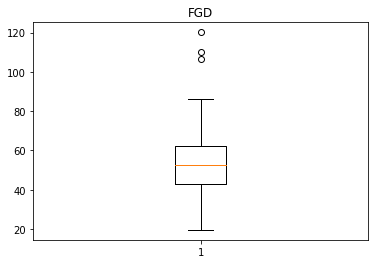

FGD mean and std for noisy data with psnr of  0.3163 : 55.15236373306894 20.59408207463085


In [32]:
n = 50 #number of test
save = True
#Writing FGD txt file for each std and then load it afterwards to plot it better 

cov_ls, cov_lsn = np.empty((n*len(stds), 32, 32)), np.empty((n*len(stds), 32, 32))
mean_ls, mean_lsn = np.empty((n*len(stds), 32)), np.empty((n*len(stds), 32))
latent_spaces_noisy_all = []
if save:
    with open(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2_onenoise.txt','w') as f: 
        j = 0
        for std in stds:
            fgds = []
            for _ in tqdm(range(n)):
            
                val_dataset_noisy = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method=method, std=std, one_noise_to_all=True)
                test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)
                latent_spaces = compute_latent_space(test_loader, generator, args.variational_encoding)
                latent_spaces_noisy_gt = compute_latent_space(test_loader_noisy, generator, args.variational_encoding)
                latent_spaces_noisy_all.append(latent_spaces_noisy_gt.detach().cpu().numpy())
                fgd, mean_ls_, mean_lsn_, cov_ls_, cov_lsn_ = compute_fgd(latent_spaces, latent_spaces_noisy_gt)
                mean_ls[j], mean_lsn[j], cov_ls[j], cov_lsn[j] = mean_ls_, mean_lsn_, cov_ls_, cov_lsn_
                fgds.append(fgd)
                j = j + 1
                
            fig1, ax1 = plt.subplots()
            ax1.set_title('FGD')
            ax1.boxplot(fgds)
            plt.show()

            print('FGD mean and std for noisy data with psnr of ', std , ':', np.array(fgds).mean(), np.array(fgds).std())
            f.write(f'{std} {np.array(fgds).mean()} {np.array(fgds).std()}\n')
            
    np.savez_compressed(f'stats_{method}_one_sample', 
                        mean_ls = mean_ls, 
                        mean_lsn = mean_lsn, 
                        cov_ls = cov_ls, 
                        cov_lsn = cov_lsn,
                        latent_spaces_noisy=np.array(latent_spaces_noisy_all))
    
else:
    for std in  stds:
        fgds = []
        for _ in tqdm(range(n)): 
            
            val_dataset_noisy = Human36M(path, mean_dir_vec, n_poses=args.n_poses, is_train=False, augment=False, method=method, std=std, one_noise_to_all=True)
            test_loader_noisy = DataLoader(dataset=val_dataset_noisy, batch_size=args.batch_size, shuffle=False, drop_last=True)
            #latent_spaces = compute_latent_space(test_loader, generator, args.variational_encoding)
            latent_spaces_noisy_gt = compute_latent_space(test_loader_noisy, generator, args.variational_encoding, with_noise=True)
            #fgd, mean_ls_, mean_lsn_, cov_ls_, cov_lsn_ = compute_fgd(latent_spaces, latent_spaces_noisy_gt)
            #fgds.append(fgd)
        '''
        fig1, ax1 = plt.subplots()
        ax1.set_title('FGD')
        ax1.boxplot(fgds)
        plt.show()
        '''
        #print('FGD mean and std for noisy data with psnr of ', std , ':', np.array(fgds).mean(), np.array(fgds).std())

In [ ]:
save = True

with open(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2_onenoise.txt') as file:
    lines = file.readlines()
    x = np.arange(len(lines))
    zeta = np.empty(len(lines))
    mean = np.empty(len(lines))
    std = np.empty(len(lines))
    for i, line in enumerate(lines):
        zeta_, mean_, std_=line.split(" ")
        zeta_, mean_, std_ = float(zeta_), float(mean_), float(std_)
        zeta[i], mean[i], std[i] = zeta_, mean_, std_
    
fig, ax = plt.subplots()
ax.set_ylabel('Fréchet Gesture Distance')
ax.set_xticks(x)
ax.set_xticklabels(zeta)
ax.set_title(f'Fréchet Gesture Distance evolution with $\zeta$ ({method_str} noise)')
ax.bar(x, mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

plt.tight_layout()
if save:
    plt.savefig(f'../Gesture-Generation-from-Trimodal-Context/figures/{args.n_poses} frames/fgd_{method_str}_{n}_s2_onenoise.png')
else:
    plt.show()

# Debugging

## Analyze statistics from FGD

In [ ]:
stat_path_one_sample = f'stats_{method}_one_sample.npz'
mlsn_one_sample = np.load(stat_path_one_sample)['mean_lsn']
covlsn_one_sample = np.load(stat_path_one_sample)['cov_lsn']


stat_path_one_sample = f'stats_{method}.npz' 
mls = np.load(stat_path)['mean_ls']
covls = np.load(stat_path)['cov_ls']
mlsn = np.load(stat_path)['mean_lsn']
covlsn = np.load(stat_path)['cov_lsn']




import seaborn as sn
from numpy.lib.twodim_base import diag
from numpy.core.umath import sqrt

print(diag(covls[222]), diag(covlsn[222]), diag(covlsn_one_sample[222]))

print(diag(covlsn[222]) == diag(covlsn_one_sample[222]))
assert False
'''
sn.heatmap((covls[100:] - covlsn_one_sample[100:]).mean(axis=0), annot=False, fmt='g')
plt.title('Difference between covariance matrices from ground truth and altered dataset with one unique sample of gaussian noise ')
plt.figure()
sn.heatmap((covls[100:] - covlsn[100:]).mean(axis=0), annot=False, fmt='g')
plt.title('Difference between covariance matrices from ground truth and altered dataset with one sample by gesture of gaussian noise')
plt.figure()
sn.heatmap((covlsn[100:] - covlsn_one_sample[100:]).mean(axis=0), annot=False, fmt='g')
plt.title('Difference between covariance matrices from altered dataset with one sample by gesture and unique sample of gaussian noise')
plt.figure()
plt.show()
'''

'''
sn.heatmap(covls[:50].mean(axis=0), annot=False, fmt='g')
plt.title('Covariance matrix of ground truth latent space')
plt.figure()
sn.heatmap(covlsn[:50].mean(axis=0), annot=False, fmt='g') #1st std
plt.title('Covariance matrix of 1st std latent space')
plt.figure()
sn.heatmap(covlsn[50:100].mean(axis=0), annot=False, fmt='g') #2nd std 
plt.title('Covariance matrix of 2nd std latent space')
plt.figure()
sn.heatmap(covlsn[100:].mean(axis=0), annot=False, fmt='g') #3rd std
plt.title('Covariance matrix of 3rd std latent space')
plt.show()
'''
sn.heatmap(covls[200:].mean(axis=0), annot=False, fmt='g') #3rd std
plt.title('Covariance matrix of 3rd std latent space')
plt.figure()
sn.heatmap(covlsn[200:].mean(axis=0), annot=False, fmt='g') #3rd std
plt.title('Covariance matrix of 3rd std latent space')
plt.figure()
sn.heatmap(covlsn_one_sample[200:].mean(axis=0), annot=False, fmt='g') #3rd std
plt.title('Covariance matrix of 3rd std latent space')
plt.show()

plt.figure()




def covnorm(cov):
    print(cov.shape)
    cov_out = np.empty((len(cov), cov.shape[-1]  ** 2))
    for i,c in enumerate(cov):
        try:
            d = diag(c)
        except ValueError:
            return c/c
        stddev = sqrt(d.real)
        c /= stddev[:,None]
        c /= stddev[None,:]

        np.clip(c.real, -1, 1, out=c.real)
        if np.iscomplexobj(c):
            np.clip(c.imag, -1, 1, out=c.imag)
        #c = c[(idx_std*50):((idx_std+1)*50)]
        c = np.abs(c).flatten()
        cov_out[i] = c
    
    return cov_out.flatten()
    
idx_std = 4

covls = covnorm(covls[(idx_std*50):((idx_std+1)*50)])
covlsn = covnorm(covlsn[(idx_std*50):((idx_std+1)*50)])
covlsn_one_sample = covnorm(covlsn_one_sample[(idx_std*50):((idx_std+1)*50)])

fig, ax = plt.subplots()
ax.set_title('Covariance matrices analysis')
ax.boxplot([covls, covlsn, covlsn_one_sample])
#ax.boxplot(covlsn)
# ax.boxplot(covlsn_one_sample)
plt.show()

#covlsn = covnorm(covlsn)
#covlsn_one_sample = covnorm(covlsn_one_sample)


#covlsn = np.abs(covlsn[((idx_std-1)*50):].reshape(len(covls),-1))
#covlsn_one_sample = np.abs(covlsn_one_sample[((idx_std-1)*50):].reshape(len(covls),-1))



## Check if noise is well adapted to each mode

In [ ]:
data = np.load("noises_one_sample.npz")['arr_0']
plt.plot(data.reshape(len(data), -1))
plt.show()

## Check the latent space

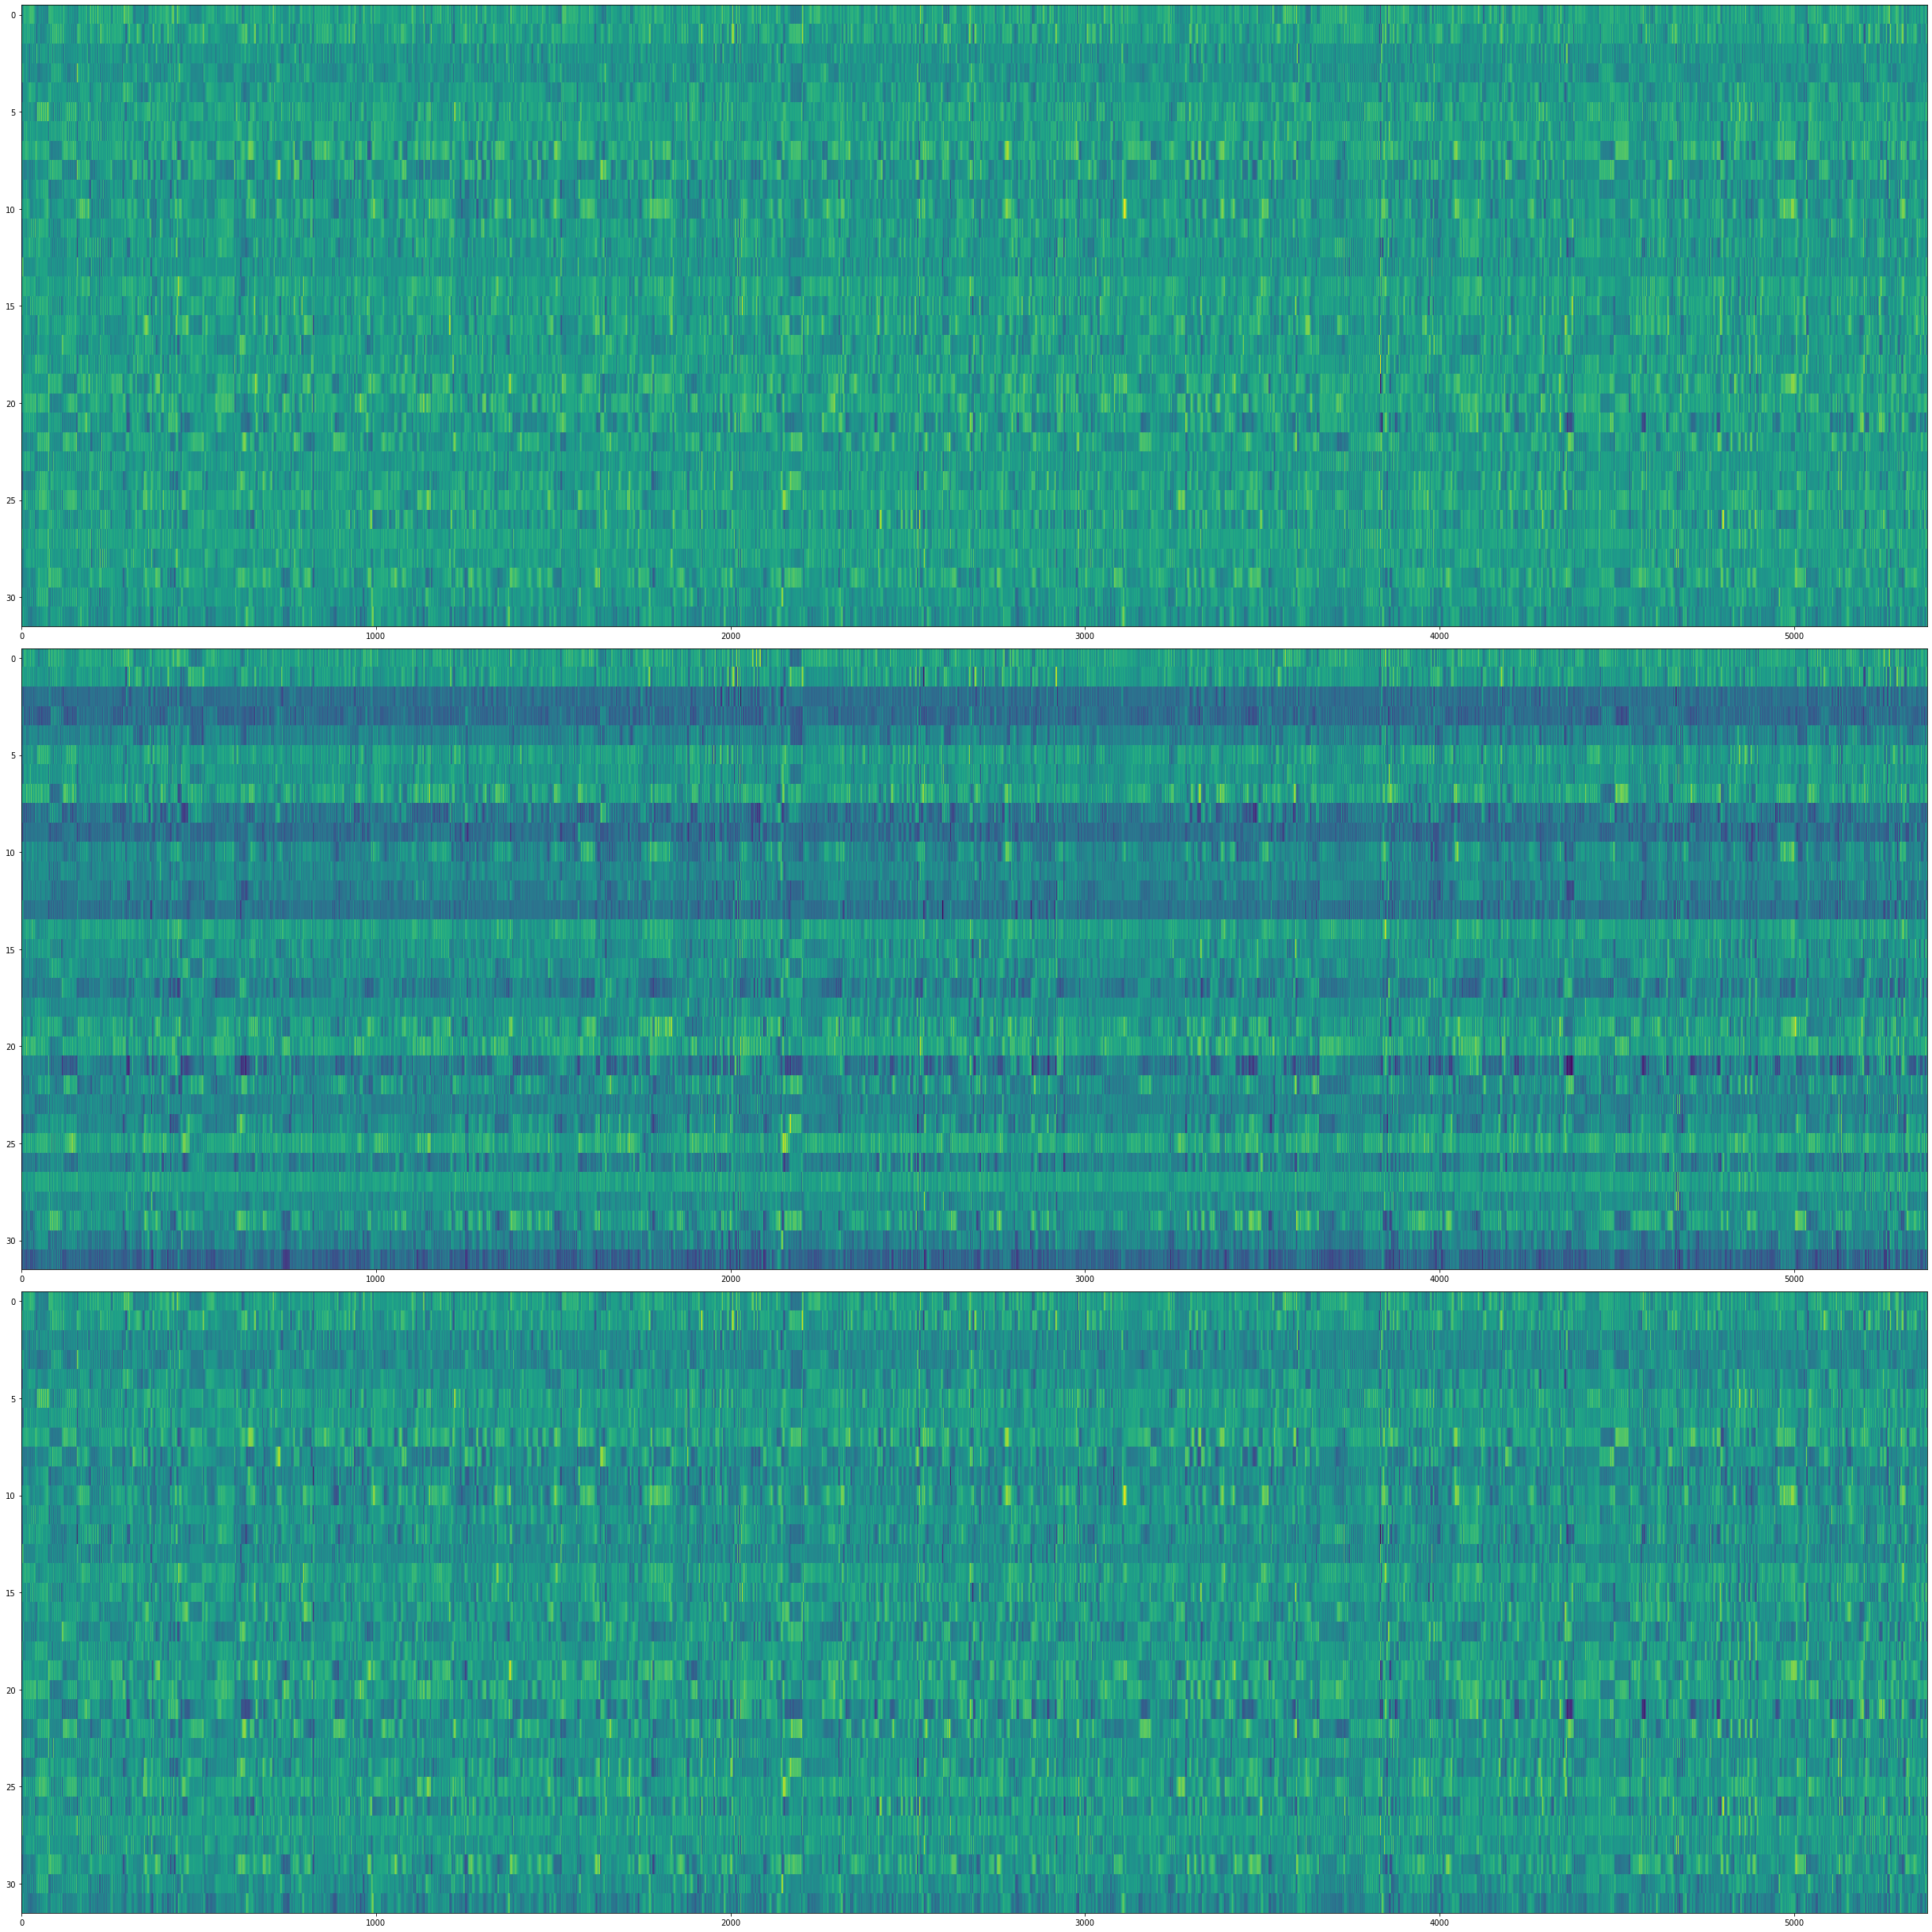

In [50]:
stat_path_one_sample = f'stats_{method}_one_sample.npz'
stat_path = f'stats_{method}.npz'

latent_spaces_noisy_one_sample = np.load(stat_path_one_sample)['latent_spaces_noisy']
latent_spaces_noisy = np.load(stat_path)['latent_spaces_noisy']
latent_spaces_gt = np.load(stat_path)['latent_spaces']

def get_win_std(x, idx):
    return x[idx*n:(idx+1)*n]


idx = 4
latent_spaces_gt = get_win_std(latent_spaces_gt, idx).mean(axis=0)
latent_spaces_noisy = get_win_std(latent_spaces_noisy, idx).mean(axis=0)
latent_spaces_noisy_one_sample = get_win_std(latent_spaces_noisy_one_sample, idx).mean(axis=0)

fig, ax = plt.subplots(3, figsize=(34,34))
ax[0].imshow(latent_spaces_gt.transpose(), interpolation="nearest", aspect='auto')
#plt.figure()
ax[1].imshow(latent_spaces_noisy.transpose(), interpolation="nearest", aspect='auto')
#plt.figure()
ax[2].imshow(latent_spaces_noisy_one_sample.transpose(), interpolation="nearest", aspect='auto')
plt.tight_layout()


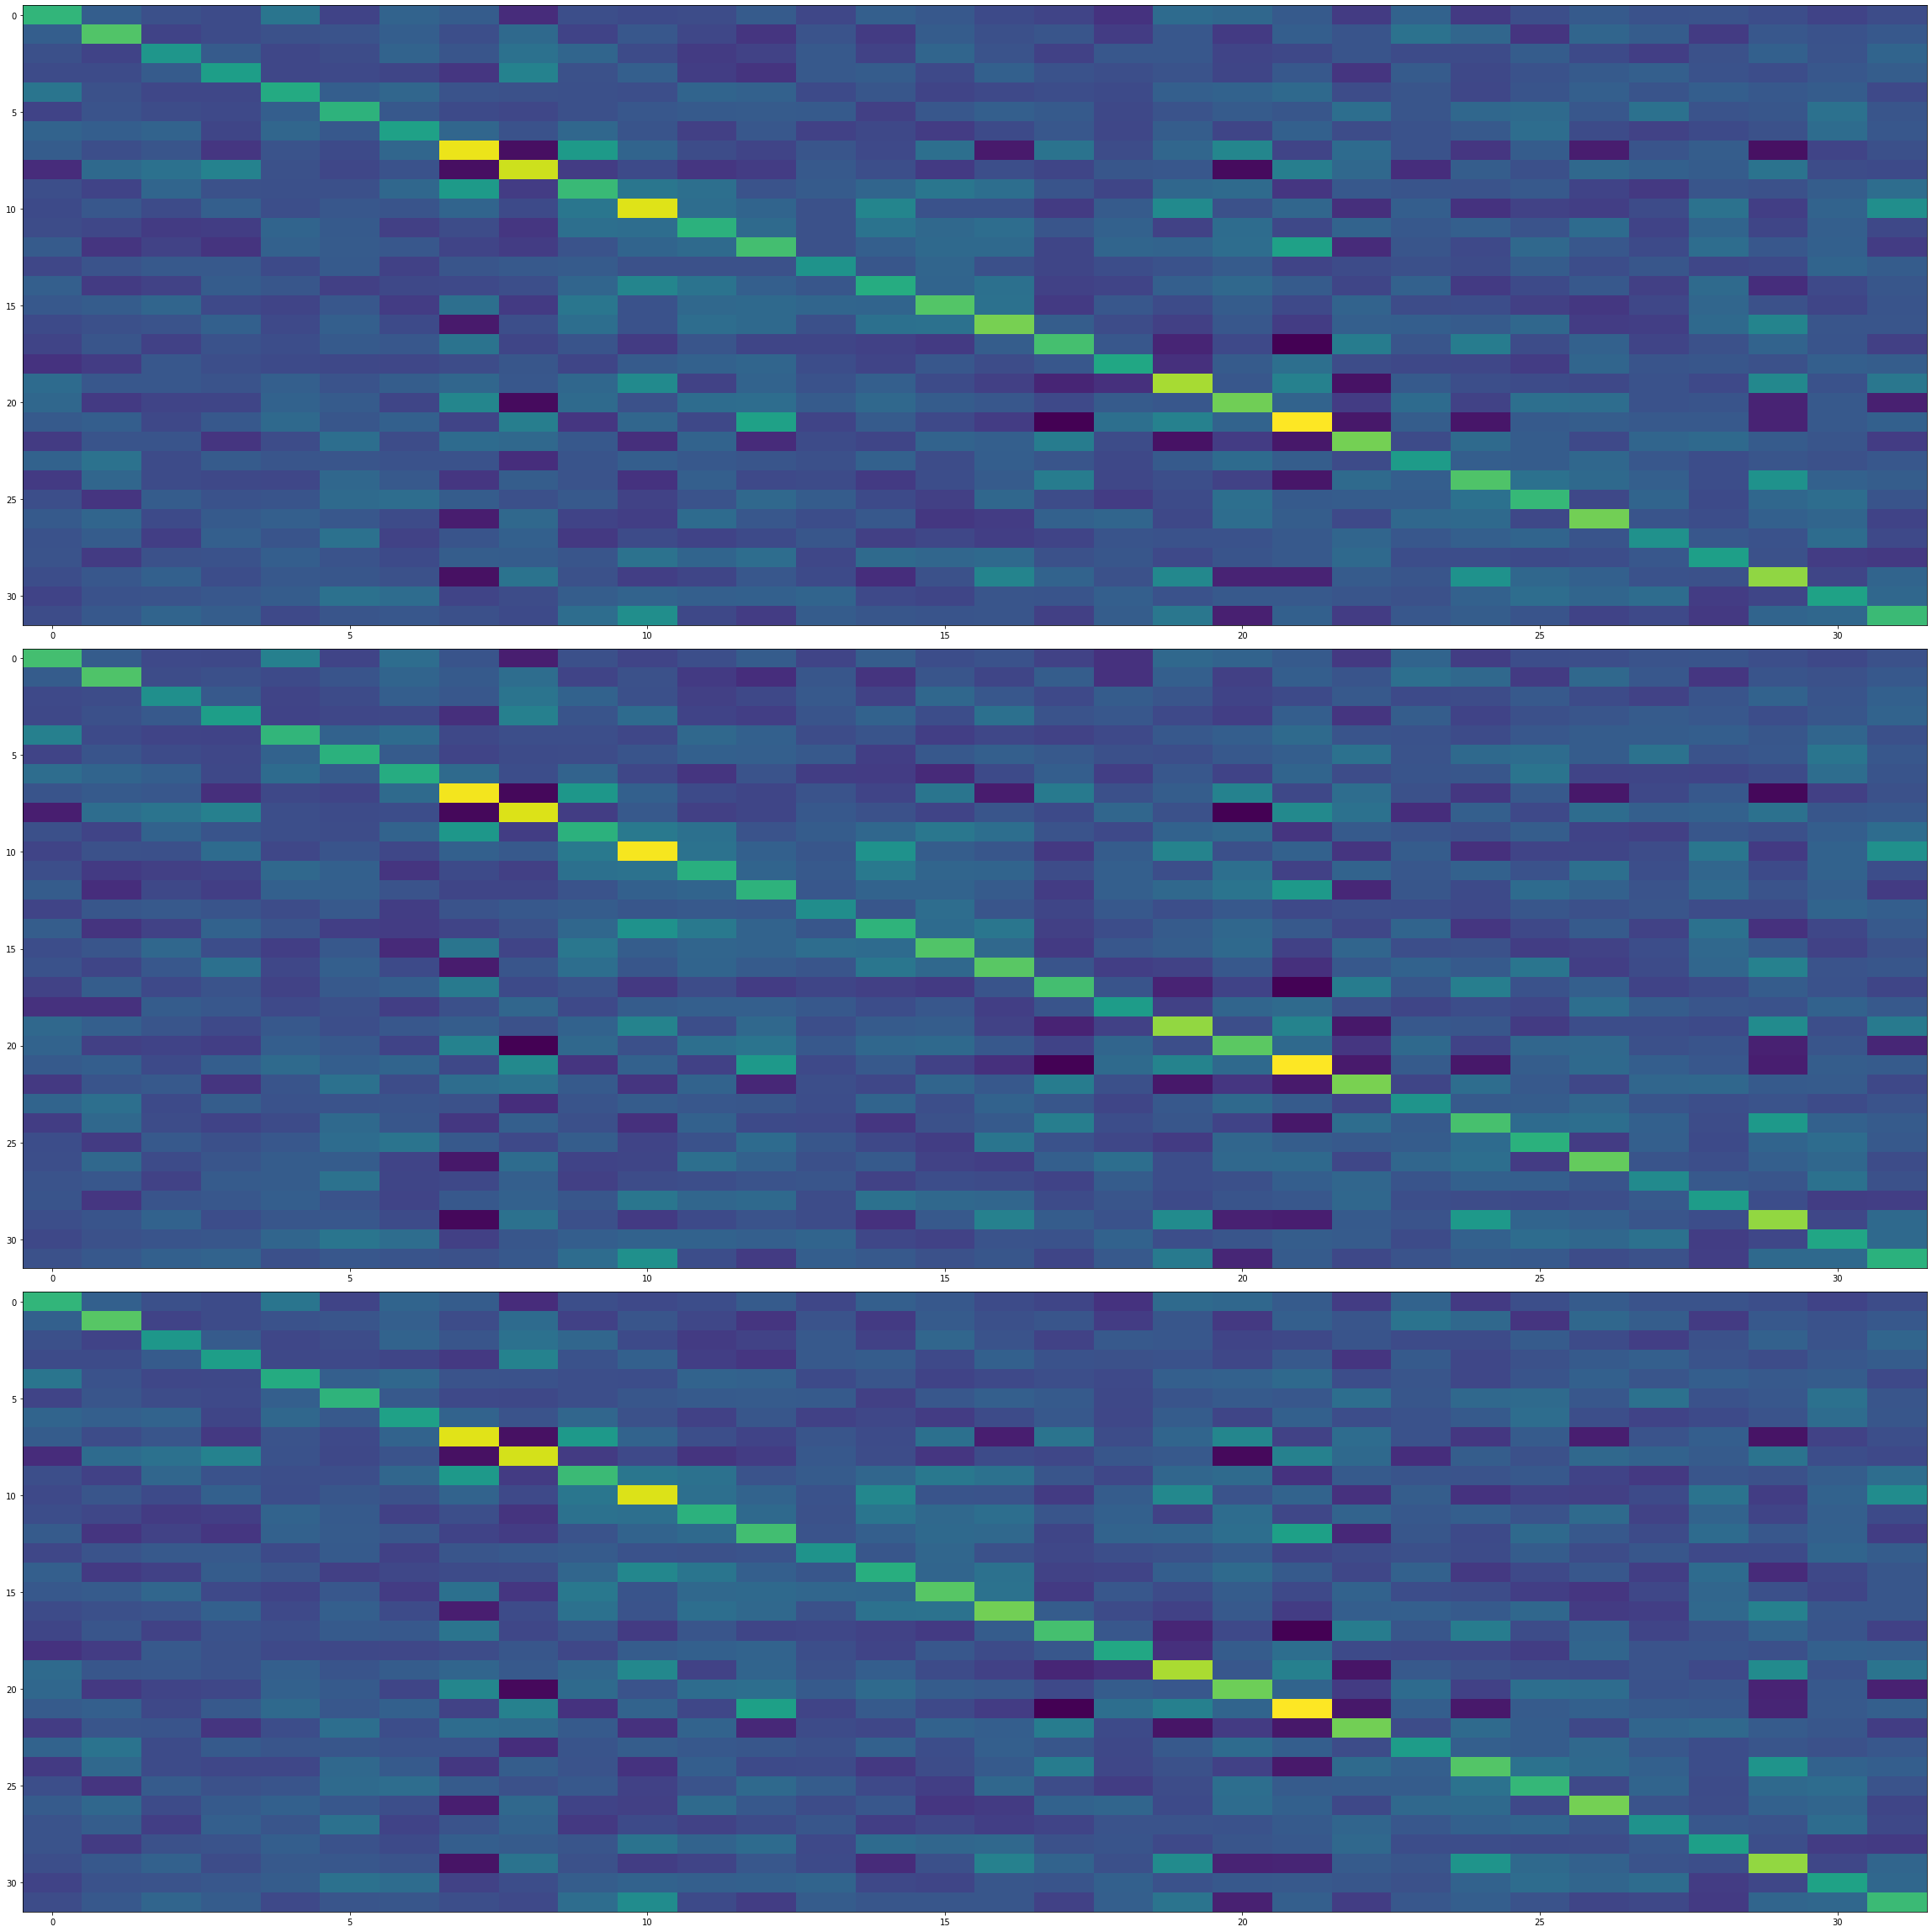

In [60]:
cov_noisy_one_sample = np.load(stat_path_one_sample)['cov_lsn']
cov_noisy = np.load(stat_path)['cov_lsn']
cov_gt = np.load(stat_path)['cov_ls']

idx = 0

cov_noisy_one_sample = get_win_std(cov_noisy_one_sample, idx).mean(axis=0)
cov_noisy = get_win_std(cov_noisy, idx).mean(axis=0)
cov_gt = get_win_std(cov_gt, idx).mean(axis=0)

fig, ax = plt.subplots(3, figsize=(32,32))
ax[0].imshow(cov_gt, interpolation="nearest", aspect='auto')
#plt.figure()
ax[1].imshow(cov_noisy, interpolation="nearest", aspect='auto')
#plt.figure()
ax[2].imshow(cov_noisy_one_sample, interpolation="nearest", aspect='auto')
plt.tight_layout()

In [61]:
cov_noisy == cov_noisy_one_sample

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## -------------------------- END ---------------------------
Below are just cells for testing piece of codes

## TSNE on latent space

In [ ]:
n_components=3
tsne_latent_spaces=compute_and_save_tsne(3,latent_spaces,latent_spaces_noisy_gt, psnr)

## Decoding data from latent space

In [ ]:
output = generator.decoder(latent_spaces_noisy_gt).detach().cpu().numpy() + np.array(args.mean_dir_vec)
decoded_noisy_motion = convert_dir_vec_to_pose(output)
#decoded_noisy_motion = convert_dir_vec_to_pose(generator.decoder(latent_spaces).detach().cpu().numpy())
save = False

if save:
    np.savez(f'gt_noise_decoded_{psnr}.npz', data=decoded_noisy_motion)

In [ ]:
#Test code for decoding ground truth motion

mean_data = np.array(args.mean_dir_vec)
outs,zs = None, None

psnr = 1
target_poses_noisy = add_noise_on_pose(target_poses, psnr)
noisy_dataset = TensorToDataset(target_poses_noisy)
noisy_loader = DataLoader(dataset=noisy_dataset, batch_size = args.batch_size, shuffle=False, drop_last = True)

dataset=noisy_loader
#for _, (target_pose, target_vec) in enumerate(test_loader):
for _, target_vec in enumerate(dataset):
    if dataset == noisy_loader:
        target_vec = target_vec.reshape(len(target_vec), args.n_poses, -1)
    z, _, _ = generator.pose_encoder(target_vec.to(device), False)
    out = generator.decoder(z)
    if outs is not None:
        z = torch.cat((zs, z), 0)
        outs = np.concatenate((outs,out.detach().cpu().numpy() + mean_data ), 0)
    else:
        outs = out.detach().cpu().numpy() + mean_data
        zs = z

save = True
if save:
    #np.savez('z.npz', data=z.detach().cpu().numpy())
    np.savez(f'gt_noise_decoded_{psnr}.npz', data =convert_dir_vec_to_pose(outs))

## Compute FGDs

In [ ]:
n = 50 #number of test
method = 'gaussian'

if method == 'gaussian':
    psnrs = [0.001,0.002,0.003]
elif method == 'salt_and_pepper_noise':
    psnrs = [0.1,0.15,0.2] #This is not psnr!

with open(f'fgd_{method}_{n}.txt','w') as f:
    for psnr in psnrs:
        fgds = []
        for _ in tqdm(range(n)):
            '''
            if method == 'gaussian':
                target_poses_noisy = add_noise_on_pose(target_poses, psnr)
                noisy_dataset = TensorToDataset(target_poses_noisy)
            elif method == 'salt_and_pepper_noise':
                noisy_dataset = TensorToNoisyDataset(target_poses, psnr, method=method)
            '''
            noisy_dataset = TensorToNoisyDataset(target_poses, psnr, method=method)
            noisy_loader = DataLoader(dataset=noisy_dataset, batch_size = args.batch_size, shuffle=False, drop_last = True)
            latent_spaces_noisy_gt = compute_latent_space(noisy_loader)
            fgd = compute_fgd(latent_spaces, latent_spaces_noisy_gt)
            fgds.append(fgd)

        fig1, ax1 = plt.subplots()
        ax1.set_title('FGD')
        ax1.boxplot(fgds)
        plt.show()

        print('FGD mean and std for noisy data with psnr of ', psnr , ':', np.array(fgds).mean(), np.array(fgds).std())
        f.write(f'{psnr} {np.array(fgds).mean()} {np.array(fgds).std()} \n')
    

## Plot FGD along psnr

In [ ]:
with open(f'fgd_{method}_{n}.txt') as file:
    lines = file.readlines()
    x = np.arange(len(lines))
    psnr = np.empty(len(lines))
    mean = np.empty(len(lines))
    std = np.empty(len(lines))
    for i, line in enumerate(lines):
        psnr_, mean_, std_=line.split(" ")
        psnr_, mean_, std_ = float(psnr_), float(mean_), float(std_)
        psnr[i], mean[i], std[i] = psnr_, mean_, std_
    
fig, ax = plt.subplots()
ax.set_ylabel('Fréchet Gesture Distance')
ax.set_xticks(x)
ax.set_xticklabels(psnr)
ax.set_title(f'Fréchet Gesture Distance evolution with $\zeta$ ({method} noise)')
ax.bar(x, mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
psnr = 0.1
method = 'saltandpepper_noise'

noisy_dataset = TensorToNoisyDataset(target_poses, psnr, method=method)
noisy_loader = DataLoader(dataset=noisy_dataset, batch_size = args.batch_size, shuffle=False, drop_last = True)

In [ ]:
simdata = np.zeros((34,10,3))
std = 10 
r = np.random.randint(0,args.n_poses - std - 1)
noise = np.random.random((std, 10, 3))
simdata = simdata[r:r+std] + noise

In [ ]:
r = np.random.randint(0,args.n_poses - std - 1)
r

In [ ]:
import pandas as pd

print(target_vecs.shape)
df = pd.DataFrame(target_vecs)
c = df.corr().abs()

print(c)
s = c.unstack()
so = s.sort_values(kind="quicksort")